In [71]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
import astropy.coordinates as coords
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astroquery.ipac.ned import Ned
from matplotlib.patches import Ellipse
import pymc3 as pm
import arviz as az

In [44]:
galname = 'NGC 848'
subids = {'HCG 16A': 2,
          'HCG 16B': 1,
          'HCG 16C': 3,
          'HCG 16D': 4,
          'NGC 848': 5}

In [85]:
def jy_to_cm2(data,hdr):
    '''
    Convert moment 0 map into column density
    Parameters
    ----------
    data: HDU data array
    hdr: HDU header
    '''
    bunit = hdr['BUNIT']
    if bunit.lower() in ['jy/beam.m/s', 'jy/beam*m/s']:
        fac = 1.249e21
    elif bunit.lower() in ['jy/beam.km/s', 'jy/beam*km/s', 'beam-1 Jy km s-1']:
        fac = 1.249e24
    else:
        fac = 1.249e24
        print('check moment 0 units, considering "Jy/beam.km/s" but could be wrong')
    bmaj, bmin = hdr['BMAJ'] * 3600., hdr['BMIN'] * 3600.
    beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0))
    nhi = fac * data / beam_area
    return nhi

def totflux(data, hdr):
    '''Calculate total flux from an HDU
    Parameters
    ----------
    data: HDU data array
    hdr: HDU header
    '''
    cell_size = abs(hdr['CDELT1'])
    cell_area = cell_size * cell_size
    bmaj, bmin = hdr['BMAJ'], hdr['BMIN']
    beam_area = bmaj * bmin * np.pi / (4.0 * np.log(2.0) * cell_area)
    box = data.copy()
    sdv = np.nansum(box) / beam_area ### conversion from Jy/beam.km/s to Jy.km/s
    bunit = hdr['BUNIT']
    if bunit.lower() in ['jy/beam.m/s', 'jy/beam*m/s', 'beam-1 Jy m s-1']: ### convert from Jy/beam.m/s to Jy/beam.km/s
        sdv *= 1e-3
    return sdv

def himass(f, D):
    '''Calculate HI mass from flux f (Jy.km/s) and distance D (Mpc)
    Parameters
    ----------
    f: flux in Jy.km/s
    D: distance in Mpc
    '''
    m = 2.36e5 * D**2 * f
    return np.log10(m)

def extract_isophote(data, intensity_level):
    plt.figure(figsize=(8, 8))
    plt.imshow(data, origin='lower', cmap='gray')
    plt.colorbar(label='Intensity')
    contour = plt.contour(data, [intensity_level], colors='b')
    plt.clf()
    return contour

def ellipse_equation(theta, xc, yc, a, b, phi):
    """Equation of an ellipse in polar coordinates."""
    return np.array([xc + a * np.cos(theta) * np.cos(phi) - b * np.sin(theta) * np.sin(phi),
                     yc + a * np.cos(theta) * np.sin(phi) + b * np.sin(theta) * np.cos(phi)]).T

def fit_ellipse_bayesian(contour_x, contour_y):
    """Fit an ellipse to a given path using Bayesian inference."""
    # Convert the path to polar coordinates
    # x = contour_x - np.mean(contour_x)
    # y = contour_y - np.mean(contour_y)
    # theta_observed = np.arctan2(y, x)

    with pm.Model() as model:
        # Priors for the parameters
        xc = pm.Normal('xc', mu=np.mean(contour_x), sd=np.std(contour_x))
        yc = pm.Normal('yc', mu=np.mean(contour_y), sd=np.std(contour_y))
        a = pm.Uniform('a', lower=0, upper=50, testval=20)
        b = pm.Uniform('b', lower=0, upper=50, testval=10)
        phi = pm.Uniform('phi', lower=-np.pi, upper=np.pi)

        # Model
        x = contour_x - np.mean(contour_x)
        y = contour_y - np.mean(contour_y)
        theta = pm.Deterministic('theta', pm.math.arctan2(y, x))
        x_fit, y_fit = ellipse_equation(theta, xc, yc, a, b, phi)

        # Likelihood
        x_obs = pm.Normal('x_obs', mu=x_fit, sd=np.std(x), observed=contour_x)
        y_obs = pm.Normal('y_obs', mu=y_fit, sd=np.std(y), observed=contour_y)

        # Sampling
        trace = pm.sample(draws=2000, tune=1000, chains=4)

    # Extracting optimized parameters
    params_opt = {
        'xc': np.mean(trace['xc']),
        'yc': np.mean(trace['yc']),
        'a': np.mean(trace['a']),
        'b': np.mean(trace['b']),
        'phi': np.mean(trace['phi'])
    }
    print(theta)
    return params_opt, trace

def plot_ellipse(params, contour_x, contour_y):
    xc, yc, a, b, phi = params['xc'], params['yc'], params['a'], params['b'], params['phi']

    fig, ax = plt.subplots()
    ax.plot(contour_x, contour_y, 'b.')  # Plot the original path
    ellipse = Ellipse((xc, yc), 2*a, 2*b, phi * 180.0 / np.pi, edgecolor='r', facecolor='none')
    ax.add_patch(ellipse)
    ax.set_aspect('equal', 'datalim')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [86]:
subid = subids[galname]
whole_data, hdr = fits.getdata(f'hcg_cubes/hcg16_mom0_sub_{subid}.fits', header=True)
ned = Ned.query_object(galname)
pos = coords.SkyCoord(ned[0]['RA'],ned[0]['DEC'], unit='deg', frame='fk5')
wcs = WCS(hdr)
cutout = Cutout2D(whole_data, position=pos, size=10*u.arcmin, wcs=wcs)
data = cutout.data
nhi_data = jy_to_cm2(data, hdr)
contour_level = 1.248e20
contour = extract_isophote(nhi_data, contour_level)
contour_x = contour.allsegs[0][0][:, 0]
contour_y = contour.allsegs[0][0][:, 1]
params_opt, trace = fit_ellipse_bayesian(contour_x, contour_y)
for key in params_opt.keys():
    print(f'{key}: {params_opt[key]:.1f}')

check moment 0 units, considering "Jy/beam.km/s" but could be wrong


AttributeError: module 'pymc3.math' has no attribute 'arctan2'

<Figure size 800x800 with 0 Axes>

In [78]:
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xc,25.299,0.549,24.338,26.403,0.005,0.003,12385.0,6017.0,1.0
yc,24.889,0.678,23.605,26.176,0.006,0.004,11986.0,5786.0,1.0
a,5.986,0.829,4.335,7.477,0.008,0.005,11994.0,6442.0,1.0
b,6.596,0.925,4.874,8.315,0.009,0.006,11341.0,6311.0,1.0
phi,-0.024,0.096,-0.215,0.148,0.001,0.001,9671.0,6373.0,1.0


/var/folders/l6/qwhmbtrx5f77tr7lps05w56r0000gn/T/ipykernel_1024/3439659561.py:76: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ellipse = Ellipse((xc, yc), 2*a, 2*b, phi * 180.0 / np.pi, edgecolor='r', facecolor='none')


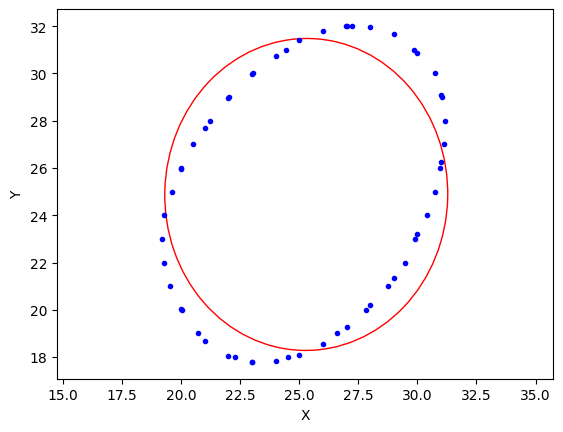

In [60]:
plot_ellipse(params_opt, contour_x, contour_y)